In [ ]:


#imports
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

import os
import json
from pandas import json_normalize

def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


In [ ]:
train = load_df(nrows=100000, csv_path="data/train.csv")
test = load_df("data/test.csv", 100000)
pd.set_option('display.max_columns', None)

Loaded train.csv. Shape: (100000, 55)
Loaded test.csv. Shape: (100000, 53)


In [ ]:
#df = df.loc[:, (df.isnull().sum(axis=0) <= max_number_of_nas)]
#train = train.loc[:, (train.eq("not available in demo dataset"))]

# Find the columns where values are not available
useless_cols = [col for col in train.columns if train[col].eq("not available in demo dataset").all()]
# Drop these columns from the dataframe
train.drop(useless_cols,
        axis=1,
        inplace=True)
train.info()

# Find the columns where values are not available
useless_cols = [col for col in train.columns if train[col].isna().all()]
# Drop these columns from the dataframe
train.drop(useless_cols,
        axis=1,
        inplace=True)
train.info()

C:\ProgramData\Anaconda\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 38 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               100000 non-null  object
 1   date                                          100000 non-null  int64 
 2   fullVisitorId                                 100000 non-null  object
 3   sessionId                                     100000 non-null  object
 4   socialEngagementType                          100000 non-null  object
 5   visitId                                       100000 non-null  int64 
 6   visitNumber                                   100000 non-null  int64 
 7   visitStartTime                                100000 non-null  int64 
 8   device.browser                                100000 non-null  object
 9   device.operatingSystem                        100000 non-nul

In [ ]:
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType', 'totals.visits']

In [ ]:
print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train :  {'totals.transactionRevenue', 'trafficSource.campaignCode'}


In [ ]:
cols_to_drop = const_cols + ['sessionId']

train_df = train.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test.drop(cols_to_drop, axis=1)

In [ ]:
from sklearn import model_selection, preprocessing, metrics
import datetime

# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0.0, inplace=True)
train_df["totals.pageviews"].fillna(0.0, inplace=True)
train_df["totals.bounces"].fillna(0.0, inplace=True)
train_df["totals.newVisits"].fillna(0.0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype(float)

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

# Split the train dataset into development and valid based on time 
#train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
dev_df = train_df[train_df['date']<=20170531]
val_df = train_df[train_df['date']>2017531]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols]

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dev_X, dev_y, random_state=0)

In [ ]:
X_train.head()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect,totals.hits,totals.pageviews,visitNumber,visitStartTime,totals.bounces,totals.newVisits
85573,1,12,0,17,459,2,190,78,7450,318,12,47,3,8098,6,3,10,626,2,1386,16,1,1,1.0,1.0,1.0,1.480437e+09,1.0,1.0
35822,2,12,0,17,317,4,58,0,7970,124,22,47,3,8098,6,3,3,626,0,1386,0,1,0,2.0,2.0,1.0,1.493707e+09,0.0,1.0
80607,2,12,1,1,0,2,142,0,3206,0,15,47,3,8098,6,3,3,626,0,1386,0,1,0,5.0,5.0,1.0,1.471878e+09,0.0,1.0
875,4,12,0,3,459,2,190,78,0,318,12,47,3,8098,6,3,3,5,5,1386,74,1,1,18.0,12.0,1.0,1.472838e+09,0.0,1.0
87560,2,12,1,1,0,2,190,0,4047,0,12,47,3,8098,6,3,3,626,0,1386,0,1,0,1.0,1.0,1.0,1.489842e+09,1.0,1.0


In [ ]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
val_pred = reg.predict(X_test[1:2])

In [ ]:
reg.score(X_test, y_test)

0.3322613937319503

In [ ]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

NameError: name 'pred_val' is not defined

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

some_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
    ('GBR', GradientBoostingRegressor(random_state=0))
])

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

train_df["revenue_cat"] = pd.cut(train_df["totals.transactionRevenue"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_df, train_df["revenue_cat"]):
    strat_train_set = train_df.loc[train_index]
    strat_test_set = train_df.loc[test_index]
    

#for set_ in (strat_train_set, strat_test_set):
 #   set_.drop("income_cat", axis=1, inplace=True)

strat_train_set = strat_train_set.drop(['revenue_cat'], axis=1)
strat_test_set= strat_test_set.drop(['revenue_cat'], axis=1)



We can tell that there appears to be no missing values

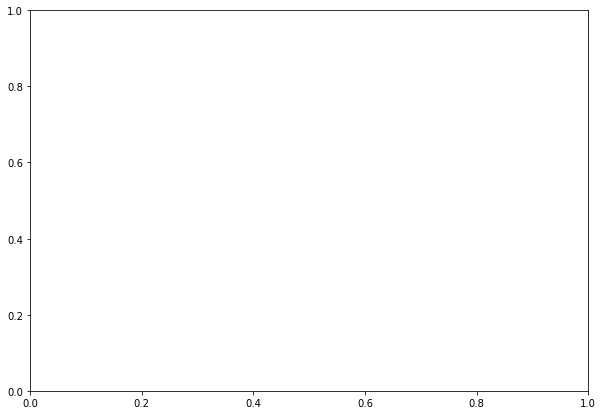

In [ ]:

import matplotlib.pyplot as plt

train.plot(kind="scatter", x="geoNetwork.longitude", y="geoNetwork.latitude", alpha=0.4,
    #s=training["totals.transactionRevenut"]/100, label="transactionRevenue", 
    figsize=(10,7),
    c="totals.transactionRevenue", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)


In [ ]:
train["geoNetwork.longitude"]

In [16]:
train["totals.transactionRevenue"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
99995    NaN
99996    NaN
99997    NaN
99998    NaN
99999    NaN
Name: totals.transactionRevenue, Length: 100000, dtype: object

In [ ]:
train.head()

Maybe add columns for lat/long using another dataset like https://simplemaps.com/data/world-cities

In [ ]:
payingCustomers = train.loc[train['totals.transactionRevenue'].notna()]
payingCustomers

In [ ]:
payingCustomers.describe()

In [ ]:
payingCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 752 to 99743
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   channelGrouping                               1399 non-null   object
 1   date                                          1399 non-null   int64 
 2   fullVisitorId                                 1399 non-null   object
 3   sessionId                                     1399 non-null   object
 4   socialEngagementType                          1399 non-null   object
 5   visitId                                       1399 non-null   int64 
 6   visitNumber                                   1399 non-null   int64 
 7   visitStartTime                                1399 non-null   int64 
 8   device.browser                                1399 non-null   object
 9   device.operatingSystem                        1399 non-null   object
 1

In [ ]:
payingCustomers["channelGrouping"].value_counts()

In [ ]:
payingCustomers["date"].value_counts()

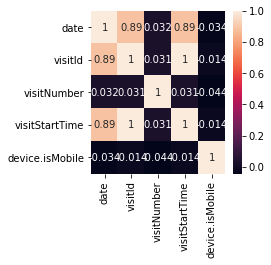

In [ ]:
import seaborn as sns
cor = payingCustomers.corr()
plt.figure(figsize=(3,3))
sns.heatmap(cor, annot=True)

## Transformers

In [43]:
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

class FeatureReducer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(features, axis=1)

In [44]:
class JsonFlattener(BaseEstimator, TransformerMixin):
    def __init__(self, json_cols):
        self.json_cols = json_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in json_cols:
            col_df = json_normalize(df[column])
            col_df.columns = [f"{column}.{subcolumn}" for subcolumn in col_df.columns]
            X = X.drop(col, axis=1).merge(col_df, right_index=True, left_index=True)
        return X

Collect all columns which need to be dropped

In [45]:
useless_cols = [col for col in train.columns 
                if train[col].isna().all() 
                or train[col].eq("not available in demo dataset").all()
                or train[col].nunique(dropna=False)==1]
useless_cols = useless_cols + ["trafficSource.campaignCode"] + ["sessionId"]
useless_cols

['socialEngagementType',
 'totals.visits',
 'trafficSource.campaignCode',
 'sessionId']

Define columns which need to be flattened:

In [46]:
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

prepare_data_pipeline = Pipeline([
    ('flatten', JsonFlattener(json_cols)),
    ('reduce', FeatureReducer(useless_cols))
])

impute_values_pipeline = Pipeline([
    
])

full_pipeline = Pipeline([
    prepare_data_pipeline,
    impute_values_pipeline
])

train_pipeline = Pipeline([
    full_pipeline,
    ("impute_revenue", ColumnTransformer(
        ('revenue_imputer', SimpleImputer(strategy="constant", fill_value=0), "totals.transactionRevenue")
    ))
])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

some_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value=0))
])

TODO:

Impute missing values
    Set revnue to 0 if not present
scale

 0   channelGrouping                               100000 non-null  object
* 1   date                                          100000 non-null  int64 
- 2   fullVisitorId                                 100000 non-null  object
- 3   sessionId                                     100000 non-null  object
 4   socialEngagementType                          100000 non-null  object
- 5   visitId                                       100000 non-null  int64 
 6   visitNumber                                   100000 non-null  int64 
* 7   visitStartTime                                100000 non-null  int64 
 8   device.browser                                100000 non-null  object
 9   device.operatingSystem                        100000 non-null  object
 10  device.isMobile                               100000 non-null  bool  
 11  device.deviceCategory                         100000 non-null  object
 12  geoNetwork.continent                          100000 non-null  object
 13  geoNetwork.subContinent                       100000 non-null  object
 14  geoNetwork.country                            100000 non-null  object
 15  geoNetwork.region                             100000 non-null  object
 16  geoNetwork.metro                              100000 non-null  object
 17  geoNetwork.city                               100000 non-null  object
* 18  geoNetwork.networkDomain                      100000 non-null  object
 19  totals.visits                                 100000 non-null  object
 20  totals.hits                                   100000 non-null  object
 21  totals.pageviews                              99993 non-null   object
 22  totals.bounces                                48916 non-null   object
 23  totals.newVisits                              77263 non-null   object
 24  totals.transactionRevenue                     1399 non-null    object
 25  trafficSource.campaign                        100000 non-null  object
 26  trafficSource.source                          100000 non-null  object
 27  trafficSource.medium                          100000 non-null  object
 28  trafficSource.keyword                         44218 non-null   object
 29  trafficSource.isTrueDirect                    30454 non-null   object
 30  trafficSource.referralPath                    36473 non-null   object
 31  trafficSource.adwordsClickInfo.page           2574 non-null    object
 32  trafficSource.adwordsClickInfo.slot           2574 non-null    object
 33  trafficSource.adwordsClickInfo.gclId          2625 non-null    object
 34  trafficSource.adwordsClickInfo.adNetworkType  2574 non-null    object
 35  trafficSource.adwordsClickInfo.isVideoAd      2574 non-null    object
 36  trafficSource.adContent                       1325 non-null    object
 37  trafficSource.campaignCode                    1 non-null       object

In [ ]:
train["geoNetwork.networkDomain"].head()

In [ ]:
payingCustomers["totals.transactionRevenue"].head()

In [ ]:
payingCustomers["totals.transactionRevenue"].describe()

In [ ]:
payingCustomers.head()

## Deployment

Suggestion for deployment: Write a web API which can receive data like one or more rows from the test dataset and return a prediction for that data. We are thinking the client will send the data as JSON and receive a JSON response.

In order to make this happen, we will need to have a way to transform our data to JSON format, as well as a way to transform it back to a dataframe. 

In [38]:
train.select_dtypes(exclude=["number","bool_","object_"])

""
0
1
2
3
4
...
99995
99996
99997
99998


In [39]:
train.select_dtypes(np.number).head()

,date,visitId,visitNumber,visitStartTime
0,20160902,1472830385,1,1472830385
1,20160902,1472880147,1,1472880147
2,20160902,1472865386,1,1472865386
3,20160902,1472881213,1,1472881213
4,20160902,1472822600,2,1472822600


In [41]:
train.select_dtypes(exclude=["number","bool_","object_"])

""
0
1
2
3
4
...
99995
99996
99997
99998


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler  
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

In [33]:
def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

def fit(self, X, y=None):

    
        #OneHotEncoding all numerical values
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        #LabelEncoding all categorical values
        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [ ]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,feature_names):
        self.feature_names = feature_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.feature_names].values
    

# build pipelines
cat_attribs = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
num_attribs = #all numerical attributes

num_pipeline = Pipeline([
               ('selector',DataFrameSelector(num_attribs)),      
               ('std_scaler',StandardScaler()), 
                ]) 

# build categorical pipeline
cat_pipeline = Pipeline([
                  ('selector',DataFrameSelector(cat_attribs)),
                  ('cat_encoder',CategoricalEncoder(encoding='onehot-dense')),
              ])


# merge all the transforms using "FeatureUnion"
pipelines = FeatureUnion(transformer_list=
                             [ 
                              ('num_pipeline',num_pipeline),
                              ('cat_pipeline',cat_pipeline),
                             ])

### TODO/Checklist

* Create pipeline
    * Create transformers for:
        * Remove useless columns
        * Impute missing values
        * Transform total revenue to natural log of total revenue
        
        
* Test the model to make sure it performs well-ish
        
* Store model to a file using pickle or joblib
    
    

* Create API - The API will receive raw data in the same format as our initial CSV files. It will then have to:
    * Remove missing columns
    * impute missing values
    * any other preprocessing
    * Make prediction
    * Return a JSON object containing customer ID and transactionrevenue. 
* Test API
   
We might start by only accepting single row data and then expand to allow multiple row data. 

### If we have time:
* Display data in nice ways to gain insights
* Try different models
* Deploy API